# Linear Regression Extended

In [436]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols #for linear regression
import seaborn as sns #for heatmap
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import r2_score #R-squared
from sklearn.model_selection import train_test_split #for train and test split
from statsmodels.api import qqplot 
from scipy.stats import shapiro,ttest_ind
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Description & Pre-Processing

In [437]:
# read the data
data = pd.read_csv("HPI.csv")

In [438]:
data.head()

,City,Floor,Rooms,Sqm,District,Broker,Currency,HTML_ID,Agency,Type,Source,nFloor,Price,ID,Price_USD,price_per_sqm
0,Երևան,9.0,3.0,124.0,կենտրոն,գործակալ,$,0,1.0,Մոնոլիտ,my_realty,10.0,250000.0,93497.0,250000.0,2016.13
1,Երևան,1.0,4.0,84.0,քանաքեռ_զեյթուն,գործակալություն,$,1,1.0,Քարե,my_realty,2.0,70000.0,93495.0,70000.0,833.33
2,Երևան,1.0,2.0,58.0,մալաթիա_սեբաստիա,գործակալ,$,2,1.0,Պանելային,my_realty,9.0,48000.0,93490.0,48000.0,827.59
3,Երևան,5.0,2.0,64.0,արաբկիր,գործակալություն,$,3,1.0,Քարե,my_realty,5.0,80000.0,85156.0,80000.0,1250.00
4,Երևան,1.0,3.0,65.0,կենտրոն,գործակալություն,$,4,1.0,Քարե,my_realty,14.0,62000.0,59140.0,62000.0,953.85


In [439]:
# examine column names
print(data.columns.tolist())

['City', 'Floor', 'Rooms', 'Sqm', 'District', 'Broker', 'Currency', 'HTML_ID', 'Agency', 'Type', 'Source', 'nFloor', 'Price', 'ID', 'Price_USD', 'price_per_sqm']


In [440]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31117 entries, 0 to 31116
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   City           31117 non-null  object 
 1   Floor          31117 non-null  object 
 2   Rooms          31117 non-null  float64
 3   Sqm            31117 non-null  float64
 4   District       31117 non-null  object 
 5   Broker         10794 non-null  object 
 6   Currency       31117 non-null  object 
 7   HTML_ID        31117 non-null  int64  
 8   Agency         31117 non-null  float64
 9   Type           31117 non-null  object 
 10  Source         31117 non-null  object 
 11  nFloor         31117 non-null  float64
 12  Price          31117 non-null  float64
 13  ID             31117 non-null  float64
 14  Price_USD      31117 non-null  float64
 15  price_per_sqm  31117 non-null  float64
dtypes: float64(8), int64(1), object(7)
memory usage: 3.8+ MB


In [441]:
# we sede some mistake becayse Floor isn in the object part, but it need to be numeric
# after checking its type we see that it is mistakenly understood as a string, so we need to change it to number
print('Type_Old:', type(data.Floor.iloc[0]))

Type_Old: <class 'str'>


In [442]:
data.Floor.unique()

array(['9.0', '1.0', '5.0', '3.0', '2.0', '14.0', '4.0', '12.0', '7.0',
       '8.0', '10.0', '6.0', '16.0', '11.0', '13.0', '15.0', '17.0',
       '20.0', '21.0', '19.0', '22.0', '18.0', '0.0', '23.0', '4 ', '10 ',
       '2 ', '3 ', '1 ', '7 ', '12 ', '9 ', '8 ', '14 ', '5 ', '6 ',
       '13 ', '11 ', '15 ', '16 ', '18 ', '17 ', 'Նկուղ ', '22 ', '19 ',
       '21 ', '23 '], dtype=object)

In [443]:
data[data.Floor=='Նկուղ ']

,City,Floor,Rooms,Sqm,District,Broker,Currency,HTML_ID,Agency,Type,Source,nFloor,Price,ID,Price_USD,price_per_sqm
8250,Երևան,Նկուղ,3.0,100.0,արաբկիր,ԿԵՆՏՐՈՆ,$,467,1.0,Այլ,real_estate,3.0,110000.0,4420.0,110000.0,1100.00
9803,Երևան,Նկուղ,3.0,110.0,արաբկիր,ՆաիրաԴանիելյան,$,2037,1.0,Քարե,real_estate,1.0,123000.0,110032.0,123000.0,1118.18


In [444]:
data = data[data.Floor!='Նկուղ '].reset_index(drop=True)
data.Floor = data.Floor.astype(float)

In [445]:
data.District.value_counts()

կենտրոն             9603
արաբկիր             7062
0                   2688
շենգավիթ            2376
աջափնյակ            1612
նորք                1532
դավթաշեն            1458
մալաթիա             1233
ավան                 905
քանաքեռ              893
նոր_նորք             516
էրեբունի             468
քանաքեռ_զեյթուն      410
մալաթիա_սեբաստիա     328
այլ                   31
Name: District, dtype: int64

In [446]:
# combine District values 0 and այլ, because they convey the sane meaning
data.District = np.where(data.District == '0', 'այլ', data.District)

In [447]:
# examine columns, which have number of unique values smaller than 10
for i in data.columns.tolist():
    if data[i].nunique()<=10:
        print(i, data[i].nunique(),"\n", data[i].value_counts())

City 5 
 երևան      19723
Երևան      10792
yerevan      539
ереван        56
erevan         5
Name: City, dtype: int64
Rooms 7 
 3.0    13755
2.0     8433
4.0     4895
1.0     3195
5.0      629
6.0      158
7.0       50
Name: Rooms, dtype: int64
Currency 3 
 $    31105
€        6
֏        4
Name: Currency, dtype: int64
Agency 2 
 1.0    30629
0.0      486
Name: Agency, dtype: int64
Type 6 
 Քարե         12355
Պանելային    11546
Մոնոլիտ       6350
Այլ            717
Կասետային      141
Աղյուսե          6
Name: Type, dtype: int64
Source 3 
 list_am        20323
my_realty       7790
real_estate     3002
Name: Source, dtype: int64


In [448]:
data['District'].value_counts()

կենտրոն             9603
արաբկիր             7062
այլ                 2719
շենգավիթ            2376
աջափնյակ            1612
նորք                1532
դավթաշեն            1458
մալաթիա             1233
ավան                 905
քանաքեռ              893
նոր_նորք             516
էրեբունի             468
քանաքեռ_զեյթուն      410
մալաթիա_սեբաստիա     328
Name: District, dtype: int64

In [449]:
# check for missing values
data.isna().sum()

City                 0
Floor                0
Rooms                0
Sqm                  0
District             0
Broker           20323
Currency             0
HTML_ID              0
Agency               0
Type                 0
Source               0
nFloor               0
Price                0
ID                   0
Price_USD            0
price_per_sqm        0
dtype: int64

In [450]:
#lets check what values we have for the column with missing values (Broker)
# as it includes mainly names we can fillna with values 'other'
# also we see that the top 2 values are actually the same so we need to replace one with the another
data.Broker.value_counts()

գործակալ           3902
գործակալություն    3888
ԿԵՆՏՐՈՆ             921
ՆվերՎանեսյան        305
Գրիգոր              288
Աղաս                220
Արզուման            210
ՆաիրաԴանիելյան      194
Արամ                191
Արիս                155
Գայանե              153
Նարեկ               125
ՍևակՄելիքսեթյան      65
Լիլիթ                65
ՏիգրանԹավադյան       39
ԱրամԱվագյան          30
Սյուզի               22
Գևորգ                19
Name: Broker, dtype: int64

In [451]:
data.Broker = data.Broker.fillna('other') 
data.Broker = np.where(data.Broker=='գործակալություն', 'գործակալ', data.Broker)
#lets check again, whether everything worked
data.Broker.value_counts()

other              20323
գործակալ            7790
ԿԵՆՏՐՈՆ              921
ՆվերՎանեսյան         305
Գրիգոր               288
Աղաս                 220
Արզուման             210
ՆաիրաԴանիելյան       194
Արամ                 191
Արիս                 155
Գայանե               153
Նարեկ                125
ՍևակՄելիքսեթյան       65
Լիլիթ                 65
ՏիգրանԹավադյան        39
ԱրամԱվագյան           30
Սյուզի                22
Գևորգ                 19
Name: Broker, dtype: int64

In [452]:
# we see that for the city feature we have only Yerevan
# HTML_ID & ID are actually categorical values and they do not have numeric meaning 
# usually id-type columns do not have numerical meaning, so we need to remove them
# price_per_sqm convery information from Y and result in reverse causality
data = data.drop(['City','Currency','HTML_ID','ID','price_per_sqm','Price'], axis=1)

In [453]:
# separate data into numeric and object parts
data_num = data.select_dtypes(exclude=["object"])
data_obj = data.select_dtypes(include="object")

In [454]:
data_obj.head()

,District,Broker,Type,Source
0,կենտրոն,գործակալ,Մոնոլիտ,my_realty
1,քանաքեռ_զեյթուն,գործակալ,Քարե,my_realty
2,մալաթիա_սեբաստիա,գործակալ,Պանելային,my_realty
3,արաբկիր,գործակալ,Քարե,my_realty
4,կենտրոն,գործակալ,Քարե,my_realty


In [455]:
data_num.head()

,Floor,Rooms,Sqm,Agency,nFloor,Price_USD
0,9.0,3.0,124.0,1.0,10.0,250000.0
1,1.0,4.0,84.0,1.0,2.0,70000.0
2,1.0,2.0,58.0,1.0,9.0,48000.0
3,5.0,2.0,64.0,1.0,5.0,80000.0
4,1.0,3.0,65.0,1.0,14.0,62000.0


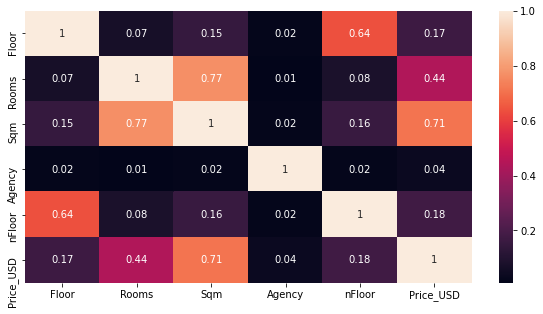

In [456]:
# correlation heatpa for examining multicollinearity
plt.figure(figsize=(10,5))
sns.heatmap(data_num.corr().abs().round(2),annot=True)

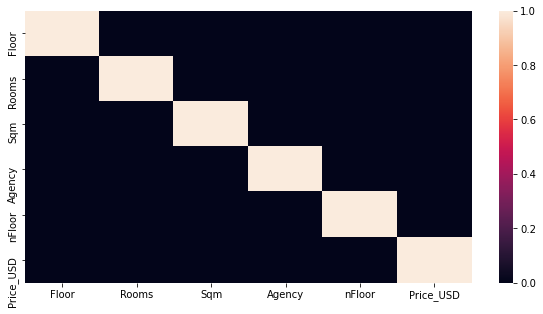

In [457]:
#plot correlation heatmap to see any correlations above or equal to 80% in absolute values
plt.figure(figsize=(10,5))
sns.heatmap(data_num.corr().abs()>=0.8)

# Model Building #1

In [458]:
# dummy
data_dummies = pd.get_dummies(data_obj, drop_first=True)
data_dummies.head()

,District_աջափնյակ,District_ավան,District_արաբկիր,District_դավթաշեն,District_էրեբունի,District_կենտրոն,District_մալաթիա,District_մալաթիա_սեբաստիա,District_նոր_նորք,District_նորք,...,Broker_ՍևակՄելիքսեթյան,Broker_ՏիգրանԹավադյան,Broker_գործակալ,Type_Այլ,Type_Կասետային,Type_Մոնոլիտ,Type_Պանելային,Type_Քարե,Source_my_realty,Source_real_estate
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [459]:
data_model = data_num.join(data_dummies, how='left')
data_model.head()

,Floor,Rooms,Sqm,Agency,nFloor,Price_USD,District_աջափնյակ,District_ավան,District_արաբկիր,District_դավթաշեն,...,Broker_ՍևակՄելիքսեթյան,Broker_ՏիգրանԹավադյան,Broker_գործակալ,Type_Այլ,Type_Կասետային,Type_Մոնոլիտ,Type_Պանելային,Type_Քարե,Source_my_realty,Source_real_estate
0,9.0,3.0,124.0,1.0,10.0,250000.0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,1.0,4.0,84.0,1.0,2.0,70000.0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2,1.0,2.0,58.0,1.0,9.0,48000.0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
3,5.0,2.0,64.0,1.0,5.0,80000.0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
4,1.0,3.0,65.0,1.0,14.0,62000.0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [460]:
Y = data_model.Price_USD
X = data_model.drop('Price_USD', axis = 1)
X = sm.add_constant(X)

In [461]:
# train-test split data
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [462]:
# linear model
model_linear = sm.OLS(Y0, X0)
results = model_linear.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     1265.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:07:07   Log-Likelihood:            -2.8595e+05
No. Observations:               23336   AIC:                         5.720e+05
Df Residuals:                   23295   BIC:                         5.723e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2.202e+04   2.94e+04     -0.748      0.454   -7.97e+04    3.57e+04
Floor                        75.2416    125.711      0.599      0.549    -171.161     321.644
Rooms                     -1.548e+04    552.805    -27.998      0.000   -1.66e+04   -1.44e+04
Sqm                        1810.6996     15.974    113.352      0.000    1779.389    1842.010
Agency                     4500.9127   2746.550      1.639      0.101    -882.506    9884.331
nFloor                      458.6333    138.262      3.317      0.001     187.631     729.636
District_աջափնյակ         -1.748e+04   1866.017     -9.366      0.000   -2.11e+04   -1.38e+04
District_ավան             -1.359e+04   2279.844     -5.959      0.000   -1.81e+04   -9117.714
District_արաբկիր           4558.1372   1365.466      3.338      0.001    1881.734    7234.540
District_դավթաշեն         -1.154e+04   1954.363     -5.907      0.000   -1.54e+04   -7712.914
District_էրեբունի         -1.145e+04   2964.433     -3.861      0.000   -1.73e+04   -5634.946
District_կենտրոն           5.303e+04   1346.521     39.380      0.000    5.04e+04    5.57e+04
District_մալաթիա          -1.465e+04   2033.042     -7.207      0.000   -1.86e+04   -1.07e+04
District_մալաթիա_սեբաստիա -1.847e+04   3575.057     -5.167      0.000   -2.55e+04   -1.15e+04
District_նոր_նորք         -1.883e+04   2959.040     -6.364      0.000   -2.46e+04    -1.3e+04
District_նորք             -1.129e+04   1910.894     -5.907      0.000    -1.5e+04   -7542.863
District_շենգավիթ         -9497.0847   1670.628     -5.685      0.000   -1.28e+04   -6222.543
District_քանաքեռ          -8575.9267   2261.223     -3.793      0.000    -1.3e+04   -4143.781
District_քանաքեռ_զեյթուն  -1.983e+04   3216.901     -6.163      0.000   -2.61e+04   -1.35e+04
Broker_Աղաս               -1409.4488   4005.467     -0.352      0.725   -9260.427    6441.530
Broker_Արամ                3910.9139   4327.784      0.904      0.366   -4571.827    1.24e+04
Broker_ԱրամԱվագյան         2452.8369   9507.052      0.258      0.796   -1.62e+04    2.11e+04
Broker_Արզուման            1.382e+04   4174.484      3.310      0.001    5635.966     2.2e+04
Broker_Արիս                5251.3400   4809.773      1.092      0.275   -4176.132    1.47e+04
Broker_Գայանե              5787.7719   4851.393      1.193      0.233   -3721.278    1.53e+04
Broker_Գրիգոր              1.736e+04   3673.331      4.726      0.000    1.02e+04    2.46e+04
Broker_Գևորգ              -5754.9661   1.29e+04     -0.447      0.655    -3.1e+04    1.95e+04
Broker_Լիլիթ              -4237.2082   6763.672     -0.626      0.531   -1.75e+04    9020.035
Broker_ԿԵՆՏՐՈՆ             -457.7342   2467.277     -0.186      0.853   -5293.759    4378.291
Broker_ՆաիրաԴանիելյան      -489.3075   4309.192     -0.114      0.910   -89

In [463]:
# check prediction on the test set
Y1_pred=results.predict(X1)
print('R^2_test:', r2_score(Y1, Y1_pred))

R^2_test: 0.6785539754079238


Test and train R^2 are very similar, so we can conclude that there is no overfitting

# Feature Engineering 

In [464]:
# transformm to the binary feature
data_obj.Broker = np.where(data_obj.Broker =='գործակալ', 1, 0)

/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [465]:
data_obj.Type.value_counts()

Քարե         12355
Պանելային    11546
Մոնոլիտ       6350
Այլ            717
Կասետային      141
Աղյուսե          6
Name: Type, dtype: int64

In [466]:
data_obj.Type = np.where(data_obj.Type.isin(['Կասետային','Աղյուսե']), 'Այլ', data_obj.Type)

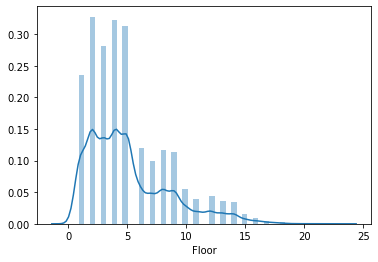

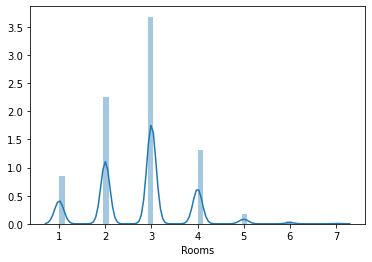

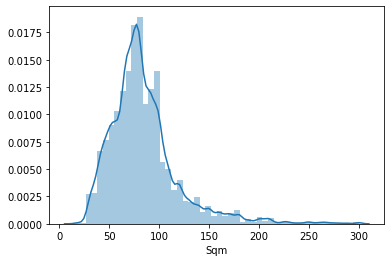

/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


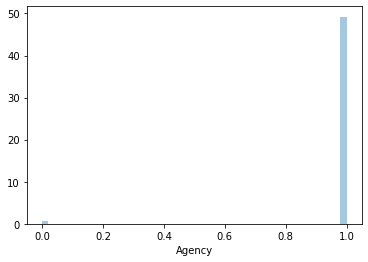

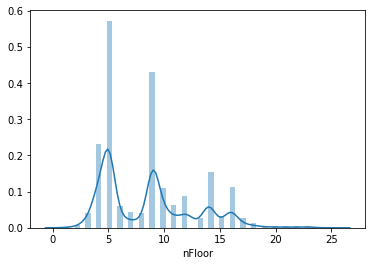

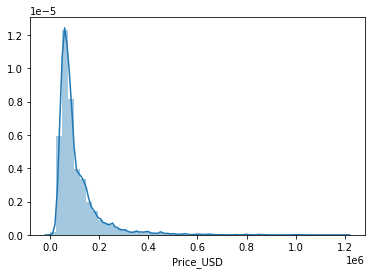

In [467]:
# let's examine the value distribution of numeric features
for i in data_num.columns.tolist():
    sns.distplot(data_num[i])
    plt.xlabel(i)
    plt.show()

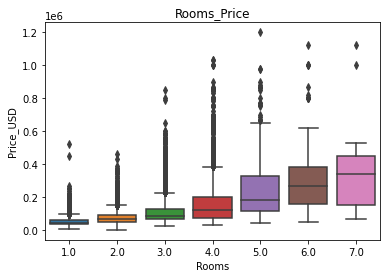

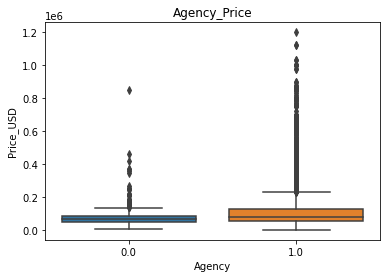

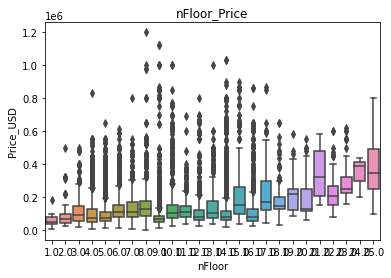

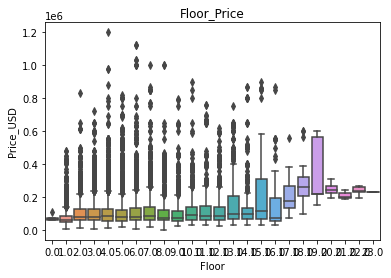

In [468]:
# boxplot for relationship between target and some object variables
for i in data_num[['Rooms','Agency', 'nFloor', 'Floor']]:
    sns.boxplot(x=data[i],y=data['Price_USD'])
    plt.title(f"{i}_Price")
    plt.show()

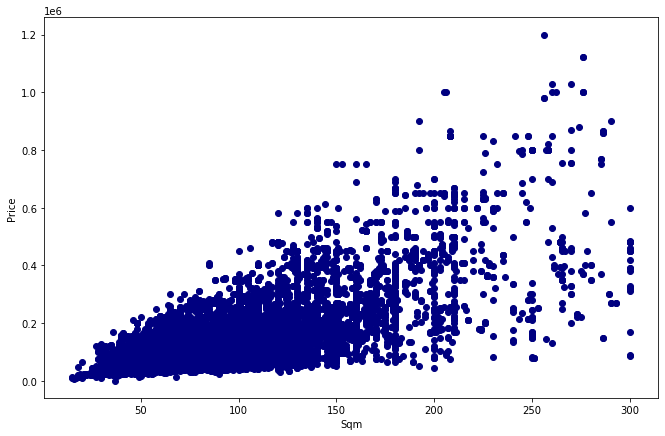

In [469]:
# scatterplot of SQM and Price to see the relationship
plt.figure(figsize = (11,7))
plt.scatter(data_num.Sqm, data_num.Price_USD, color='navy')
plt.xlabel('Sqm')
plt.ylabel('Price')
plt.show()

In [470]:
# create a sumary of average price value per room type and see the relationship
table = pd.pivot_table(data=data_num, index='Rooms', values='Price_USD', aggfunc='mean')
table

,Price_USD
Rooms,
1.0,53214.794863
2.0,79066.559856
3.0,110019.081526
4.0,162721.125483
5.0,244837.837838
6.0,306537.974684
7.0,336300.000000


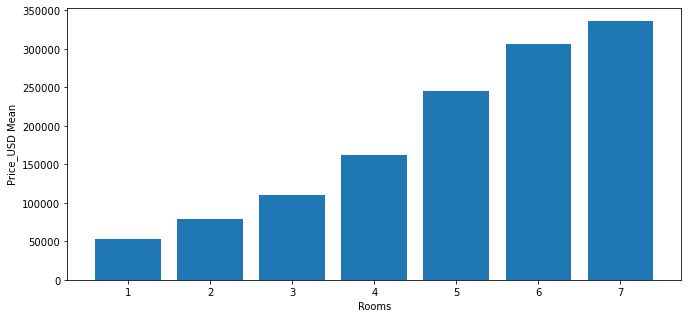

In [471]:
plt.figure(figsize = (11,5))
plt.bar(table.index, table['Price_USD'])
plt.ylabel('Price_USD Mean')
plt.xlabel('Rooms')
plt.show()

In [472]:
data_num

,Floor,Rooms,Sqm,Agency,nFloor,Price_USD
0,9.0,3.0,124.0,1.0,10.0,250000.0
1,1.0,4.0,84.0,1.0,2.0,70000.0
2,1.0,2.0,58.0,1.0,9.0,48000.0
3,5.0,2.0,64.0,1.0,5.0,80000.0
4,1.0,3.0,65.0,1.0,14.0,62000.0
...,...,...,...,...,...,...
31110,3.0,1.0,32.0,1.0,5.0,49000.0
31111,8.0,4.0,92.0,1.0,10.0,150000.0
31112,3.0,3.0,90.0,1.0,5.0,79000.0
31113,2.0,2.0,70.0,1.0,4.0,81000.0


In [473]:
# features created based on the domain knowledge
data_num['bardzrahark'] = np.where(data.Floor>=10, 1, 0)
data_num['sqm_per_room'] = data_num['Sqm']/data_num['Rooms']

# features created based on the insights from visualizations
data_num['Room_groupings'] = np.where(data_num.Rooms<=2,1,np.where(data_num.Rooms >= 6,3,2))
data_num['log_SQM'] = np.log(data_num.Sqm)
data_num['Price_USD'] = np.log(data_num.Price_USD)

<ipython-input-473-f71937ed6e79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num['bardzrahark'] = np.where(data.Floor>=10, 1, 0)
<ipython-input-473-f71937ed6e79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num['sqm_per_room'] = data_num['Sqm']/data_num['Rooms']
<ipython-input-473-f71937ed6e79>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

# Model Building #2

In [474]:
# create dummies
data_dummies = pd.get_dummies(data_obj,drop_first = True)
data_dummies.head()

,Broker,District_աջափնյակ,District_ավան,District_արաբկիր,District_դավթաշեն,District_էրեբունի,District_կենտրոն,District_մալաթիա,District_մալաթիա_սեբաստիա,District_նոր_նորք,District_նորք,District_շենգավիթ,District_քանաքեռ,District_քանաքեռ_զեյթուն,Type_Մոնոլիտ,Type_Պանելային,Type_Քարե,Source_my_realty,Source_real_estate
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0


In [475]:
# merging all variables together
data_model = data_num.join(data_dummies, how='left')

In [476]:
data_model.head()

,Floor,Rooms,Sqm,Agency,nFloor,Price_USD,bardzrahark,sqm_per_room,Room_groupings,log_SQM,...,District_նոր_նորք,District_նորք,District_շենգավիթ,District_քանաքեռ,District_քանաքեռ_զեյթուն,Type_Մոնոլիտ,Type_Պանելային,Type_Քարե,Source_my_realty,Source_real_estate
0,9.0,3.0,124.0,1.0,10.0,12.429216,0,41.333333,2,4.820282,...,0,0,0,0,0,1,0,0,1,0
1,1.0,4.0,84.0,1.0,2.0,11.156251,0,21.000000,2,4.430817,...,0,0,0,0,1,0,0,1,1,0
2,1.0,2.0,58.0,1.0,9.0,10.778956,0,29.000000,1,4.060443,...,0,0,0,0,0,0,1,0,1,0
3,5.0,2.0,64.0,1.0,5.0,11.289782,0,32.000000,1,4.158883,...,0,0,0,0,0,0,0,1,1,0
4,1.0,3.0,65.0,1.0,14.0,11.034890,0,21.666667,2,4.174387,...,0,0,0,0,0,0,0,1,1,0


In [477]:
Y = data_model["Price_USD"]
X = data_model.drop("Price_USD", axis=1)
X = sm.add_constant(X)

In [478]:
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [479]:
# linear model
model_linear = sm.OLS(Y0, X0)
results = model_linear.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     3331.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:07:11   Log-Likelihood:                -2770.3
No. Observations:               23336   AIC:                             5597.
Df Residuals:                   23308   BIC:                             5822.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         8.5666      0.062    138.727      0.000       8.446       8.688
Floor                        -0.0009      0.001     -1.006      0.314      -0.003       0.001
Rooms                        -0.0791      0.008     -9.883      0.000      -0.095      -0.063
Sqm                           0.0047      0.000     21.585      0.000       0.004       0.005
Agency                        0.0536      0.015      3.634      0.000       0.025       0.082
nFloor                        0.0063      0.001      8.250      0.000       0.005       0.008
bardzrahark                  -0.0486      0.009     -5.470      0.000      -0.066      -0.031
sqm_per_room                 -0.0036      0.001     -7.125      0.000      -0.005      -0.003
Room_groupings                0.0416      0.007      5.941      0.000       0.028       0.055
log_SQM                       0.5645      0.018     30.890      0.000       0.529       0.600
Broker                        0.0380      0.002     15.720      0.000       0.033       0.043
District_աջափնյակ            -0.2498      0.010    -24.960      0.000      -0.269      -0.230
District_ավան                -0.1497      0.012    -12.229      0.000      -0.174      -0.126
District_արաբկիր              0.1078      0.007     14.709      0.000       0.093       0.122
District_դավթաշեն            -0.0437      0.010     -4.162      0.000      -0.064      -0.023
District_էրեբունի            -0.2205      0.016    -13.857      0.000      -0.252      -0.189
District_կենտրոն              0.4400      0.007     60.853      0.000       0.426       0.454
District_մալաթիա             -0.2252      0.011    -20.620      0.000      -0.247      -0.204
District_մալաթիա_սեբաստիա    -0.2518      0.019    -13.141      0.000      -0.289      -0.214
District_նոր_նորք            -0.2156      0.016    -13.691      0.000      -0.246      -0.185
District_նորք                -0.2251      0.010    -22.071      0.000      -0.245      -0.205
District_շենգավիթ            -0.2485      0.009    -27.690      0.000      -0.266      -0.231
District_քանաքեռ             -0.1586      0.012    -13.062      0.000      -0.182      -0.135
District_քանաքեռ_զեյթուն     -0.1901      0.017    -11.032      0.000      -0.224      -0.156
Type_Մոնոլիտ                  0.2462      0.012     20.841      0.000       0.223       0.269
Type_Պանելային               -0.1108      0.011     -9.693      0.000      -0.133      -0.088
Type_Քարե                     0.0207      0.011      1.806      0.071      -0.002       0.043
Source_my_realty              0.0380      0.002     15.720      0.000       0.033       0.043
Source_real_estate            0.0745      0.007     11.266      0.000       0.062       0.088
===========================================================================

In [480]:
# check prediction on the test set
Y1_pred=results.predict(X1)
print('R^2_test:', r2_score(Y1, Y1_pred))

R^2_test: 0.7954684152601414


We have seen how we can significantly improve the sxame model based solely on feature engineering

### Interpretation of the results of Linear Regression
R-squared and F-statistics: As Prob (F-statistic) shows our model is statistically significant at 5%(even 1%) significance level, so there is at least one estimated coefficient (besides intercept) that is not null. R-squared shows that 79% of variance in car prices is explained by the variables included in the model.

Adj. R-squared (79%) is the same as R-squared, which means that included variables are important.

<b>CStatistically significant variables:</b>
<ul>
<li>All vairables, except the Fllor as statistically significant, they have p-value smaller than 0.05. </li>
</ul>


<b>Coefficients (continous variable):</b>
<ul>
<li>For each unit increase in SQM we will experience on average about 0.0047 increase in log price of a house. Please not that we are interpreting the effect on the LOGARITHM of the price.</li>
</ul>

<b>CCoefficients (categorical variable)</b>
<ul>
<li>the reference category for type is 'other'. So if a house type is stone rather than smth else then on average 0.0207 unit increase is expected in mean log of a house. </li>
</ul>

CPlease note that if the variable is in the model and you have no possibility or you do not want to remove it it should be in the final model formulation even if it is not statistically significant

<b>lOG_Price = 8.5666 - 0.0009*Floor - 0.0791*Rooms + 0.0047*SQM ............</b>

## Sklearn linear regression

In [481]:
# we specify do not fit intercept because we already have the constant feature
reg = linear_model.LinearRegression(fit_intercept=False).fit(X0, Y0)
print('R^2_train:', reg.score(X0, Y0))
print('R^2_test:', reg.score(X1, Y1))

R^2_train: 0.7942032785052594
R^2_test: 0.7954684152601316


In [482]:
reg.coef_

array([ 8.56659403e+00, -8.77026469e-04, -7.91041072e-02,  4.67821824e-03,
        5.35877029e-02,  6.26618741e-03, -4.86298736e-02, -3.63855880e-03,
        4.16069636e-02,  5.64474572e-01,  3.80386069e-02, -2.49827131e-01,
       -1.49702680e-01,  1.07824065e-01, -4.36520298e-02, -2.20455986e-01,
        4.39990433e-01, -2.25204767e-01, -2.51847131e-01, -2.15583637e-01,
       -2.25060126e-01, -2.48456642e-01, -1.58622773e-01, -1.90140140e-01,
        2.46162835e-01, -1.10787842e-01,  2.07242964e-02,  3.80386069e-02,
        7.45493778e-02])

In [483]:
# the package do not have the same summary, and the code below only provides the features and respective coefficients
coef = pd.DataFrame(dict(zip(X0.columns, reg.coef_)), index=[0]).T
coef.columns=['coef']
coef

,coef
const,8.566594
Floor,-0.000877
Rooms,-0.079104
Sqm,0.004678
Agency,0.053588
nFloor,0.006266
bardzrahark,-0.048630
sqm_per_room,-0.003639
Room_groupings,0.041607
log_SQM,0.564475


For implementing Lasso regression change <i>LinearRegression</i> to <i>Lasso</i> 

# Model diagnostics

In [484]:
#residuals of the model
residuals=results.resid
residuals.head(10)

15468    0.086244
20030   -0.014716
24882   -0.108770
30928   -0.243505
19885   -0.063008
20053    0.318932
16716    0.112945
9918     0.413869
25902   -0.027377
2766     0.152443
dtype: float64

In [485]:
pred_values=results.predict()

## Linearity and Equal variance

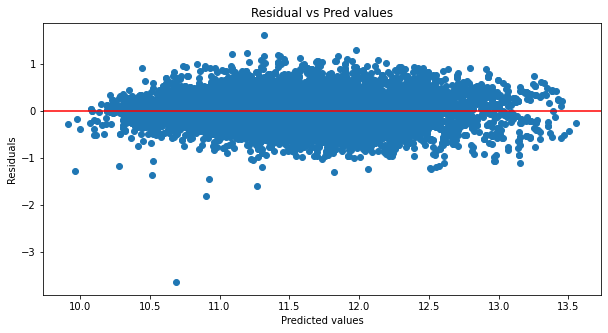

In [486]:
#lets plot predicted values vs residuals to see whether there is any pattern or no
plt.figure(figsize=(10,5))
plt.scatter(pred_values,residuals)
plt.axhline(y=0, c="red")
plt.title("Residual vs Pred values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

In [487]:
#Breusch-Pagan test for homoscedasticity
#The null hypothesis assumes homoskedasticity
bnames = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
breush = het_breuschpagan(residuals, results.model.exog)
print(list(zip(bnames, breush)))

[('Lagrange multiplier statistic', 1758.4217333586064), ('p-value', 0.0), ('f-value', 70.34959272289137), ('f p-value', 0.0)]


We have a small p-value, so we have enough evidence to reject the homoscedasticity assumtion. 
Homoscedasticity assumption is NOT held.

In [488]:
# Rainbow test for linearity 
# The null hypothesis assumes linearity
rnames=["fstat", "p-value"]
rainbow=linear_rainbow(results)
print(list(zip(rnames, rainbow)))

[('fstat', 1.0122595043463511), ('p-value', 0.25537177232956765)]


Linearity assumption is  held (fail to reject), since we have a p-value>0.05.

## Normality

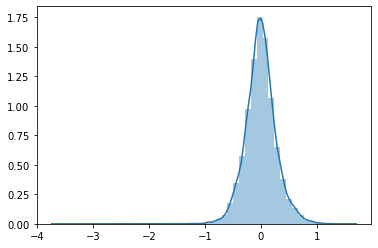

In [489]:
#distribution of residuals
sns.distplot(residuals)
plt.show()

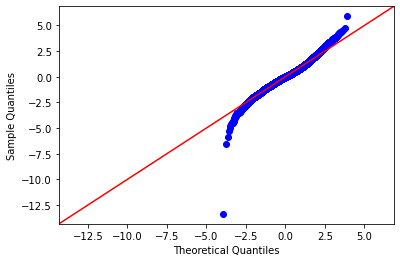

In [490]:
#QQ plot
qqplot(residuals,fit=True, line='45')
plt.show()

In [491]:
#Shapiro-Wilk normality test. 
#The null-hypothesis of this test is that the data was drawn from a normal distribution
snames=['The test statistic', 'p-value']
shapiro=shapiro(residuals)
print(list(zip(snames, shapiro)))

[('The test statistic', 0.986011266708374), ('p-value', 4.4042810733729e-42)]


/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk test shows that we have enough evidence to reject H0, so the normality assumption is not held.

### Multicolinearity (VIF)

In [492]:
features = X0.columns.tolist()

In [493]:
#Calculating VIF for all features
vif = [variance_inflation_factor(X[features].values,i) for i in range(len(features))]
vif = dict(zip(features,vif))
vif = {k:v for k,v in sorted(vif.items(),key=lambda item: item[1],reverse=True)}
vif

/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'Broker': inf,
 'Source_my_realty': inf,
 'const': 1208.0475275569452,
 'Rooms': 18.594609233514685,
 'Sqm': 18.179186720339818,
 'log_SQM': 15.63521687530344,
 'Type_Քարե': 10.01522313245293,
 'Type_Պանելային': 9.661385335399746,
 'Type_Մոնոլիտ': 7.167291343401484,
 'sqm_per_room': 6.111485888280495,
 'Room_groupings': 3.7717496476543073,
 'District_կենտրոն': 3.5074712896967846,
 'nFloor': 3.124343771310194,
 'District_արաբկիր': 2.967355322758391,
 'Floor': 2.831882577322717,
 'bardzrahark': 2.4523797011812514,
 'District_շենգավիթ': 1.7827720415430388,
 'District_աջափնյակ': 1.545749705599157,
 'District_դավթաշեն': 1.538008944586062,
 'District_նորք': 1.5086242585537946,
 'District_մալաթիա': 1.437547247749316,
 'District_ավան': 1.3312928390582621,
 'District_քանաքեռ': 1.3016235106040515,
 'District_նոր_նորք': 1.2717588325177847,
 'District_քանաքեռ_զեյթուն': 1.2140738556167459,
 'Source_real_estate': 1.1998382954777855,
 'District_մալաթիա_սեբաստիա': 1.184024368922852,
 'District_էրեբու

In [494]:
# creating a list of features to drop based on VIF
to_drop = ['Broker','Source_my_realty','Rooms','Sqm','Type_Քարե','Type_Պանելային']

In [495]:
# new features list
features1 = list(set(features)-set(to_drop))

In [496]:
vif = [variance_inflation_factor(X[features1].values,i) for i in range(len(features1))]
vif = dict(zip(features1,vif))
vif = {k:v for k,v in sorted(vif.items(),key=lambda item: item[1],reverse=True)}

In [497]:
# no need to remove other features, all of them have VIF<5
vif

{'const': 276.0865427786331,
 'log_SQM': 3.244380261895143,
 'District_կենտրոն': 3.2346123675060436,
 'Room_groupings': 3.156448153329968,
 'Floor': 2.8160086913746127,
 'District_արաբկիր': 2.815574156553201,
 'bardzrahark': 2.3772586876242956,
 'nFloor': 2.0067886841211426,
 'District_շենգավիթ': 1.7730675540724143,
 'sqm_per_room': 1.6764704372258388,
 'District_աջափնյակ': 1.5284866690465113,
 'District_դավթաշեն': 1.4979834988645966,
 'District_նորք': 1.4957924255043067,
 'District_մալաթիա': 1.4181577674589236,
 'Type_Մոնոլիտ': 1.389875269552156,
 'District_ավան': 1.304874562351572,
 'District_քանաքեռ': 1.29560899780415,
 'District_նոր_նորք': 1.1973466651333378,
 'District_էրեբունի': 1.1602626303035704,
 'District_քանաքեռ_զեյթուն': 1.1530473283948832,
 'District_մալաթիա_սեբաստիա': 1.1205316711764546,
 'Source_real_estate': 1.0645973097102839,
 'Agency': 1.011762232027846}

In [498]:
# Creating another model with new featureset
model_vif = sm.OLS(Y0,X0[features1])
results_vif = model_vif.fit()
results_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     3808.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:07:14   Log-Likelihood:                -3425.8
No. Observations:               23336   AIC:                             6898.
Df Residuals:                   23313   BIC:                             7083.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
District_կենտրոն              0.4877      0.007     68.346      0.000       0.474       0.502
Source_real_estate            0.0465      0.006      7.251      0.000       0.034       0.059
Room_groupings                0.0114      0.007      1.724      0.085      -0.002       0.024
sqm_per_room                  0.0022      0.000      8.039      0.000       0.002       0.003
District_քանաքեռ             -0.1764      0.012    -14.155      0.000      -0.201      -0.152
Type_Մոնոլիտ                  0.3457      0.005     64.438      0.000       0.335       0.356
District_մալաթիա             -0.2604      0.011    -23.343      0.000      -0.282      -0.239
District_դավթաշեն            -0.0433      0.011     -4.064      0.000      -0.064      -0.022
bardzrahark                  -0.0079      0.009     -0.877      0.381      -0.026       0.010
District_էրեբունի            -0.2050      0.016    -12.577      0.000      -0.237      -0.173
District_արաբկիր              0.1472      0.007     20.060      0.000       0.133       0.162
District_մալաթիա_սեբաստիա    -0.2012      0.019    -10.484      0.000      -0.239      -0.164
District_շենգավիթ            -0.2361      0.009    -25.652      0.000      -0.254      -0.218
District_աջափնյակ            -0.2240      0.010    -21.889      0.000      -0.244      -0.204
District_նոր_նորք            -0.1634      0.016    -10.402      0.000      -0.194      -0.133
const                         7.5290      0.031    246.781      0.000       7.469       7.589
District_նորք                -0.2384      0.010    -22.816      0.000      -0.259      -0.218
Floor                        -0.0021      0.001     -2.386      0.017      -0.004      -0.000
log_SQM                       0.8222      0.009     95.797      0.000       0.805       0.839
Agency                        0.0541      0.015      3.573      0.000       0.024       0.084
District_քանաքեռ_զեյթուն     -0.1376      0.017     -7.973      0.000      -0.171      -0.104
District_ավան                -0.1616      0.012    -12.959      0.000      -0.186      -0.137
nFloor                       -0.0054      0.001     -8.678      0.000      -0.007      -0.004
==============================================================================
Omnibus:                     1264.003   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4950.820
Skew:                           0.095   Prob(JB):                         0.00
Kurtosis:                       5.249   Cond. No.                         617.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Backward selection

In [499]:
X0 = X0[features1]
X1 = X1[features1]

In [500]:
model_1 = sm.OLS(Y0,X0.drop('bardzrahark',axis=1))
results_1 = model_1.fit()
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     3990.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:07:14   Log-Likelihood:                -3426.1
No. Observations:               23336   AIC:                             6896.
Df Residuals:                   23314   BIC:                             7074.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
District_կենտրոն              0.4878      0.007     68.367      0.000       0.474       0.502
Source_real_estate            0.0465      0.006      7.251      0.000       0.034       0.059
Room_groupings                0.0113      0.007      1.719      0.086      -0.002       0.024
sqm_per_room                  0.0022      0.000      8.025      0.000       0.002       0.003
District_քանաքեռ             -0.1766      0.012    -14.173      0.000      -0.201      -0.152
Type_Մոնոլիտ                  0.3456      0.005     64.433      0.000       0.335       0.356
District_մալաթիա             -0.2601      0.011    -23.327      0.000      -0.282      -0.238
District_դավթաշեն            -0.0431      0.011     -4.050      0.000      -0.064      -0.022
District_էրեբունի            -0.2048      0.016    -12.567      0.000      -0.237      -0.173
District_արաբկիր              0.1472      0.007     20.053      0.000       0.133       0.162
District_մալաթիա_սեբաստիա    -0.2009      0.019    -10.469      0.000      -0.238      -0.163
District_շենգավիթ            -0.2361      0.009    -25.659      0.000      -0.254      -0.218
District_աջափնյակ            -0.2241      0.010    -21.909      0.000      -0.244      -0.204
District_նոր_նորք            -0.1635      0.016    -10.405      0.000      -0.194      -0.133
const                         7.5310      0.030    247.516      0.000       7.471       7.591
District_նորք                -0.2383      0.010    -22.812      0.000      -0.259      -0.218
Floor                        -0.0026      0.001     -3.794      0.000      -0.004      -0.001
log_SQM                       0.8223      0.009     95.812      0.000       0.805       0.839
Agency                        0.0541      0.015      3.573      0.000       0.024       0.084
District_քանաքեռ_զեյթուն     -0.1378      0.017     -7.982      0.000      -0.172      -0.104
District_ավան                -0.1612      0.012    -12.938      0.000      -0.186      -0.137
nFloor                       -0.0055      0.001     -8.835      0.000      -0.007      -0.004
==============================================================================
Omnibus:                     1261.702   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4938.057
Skew:                           0.094   Prob(JB):                         0.00
Kurtosis:                       5.246   Cond. No.                         616.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [501]:
model_2 = sm.OLS(Y0,X0.drop(['bardzrahark','Room_groupings'],axis=1))
results_2 = model_2.fit()
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     4189.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:07:14   Log-Likelihood:                -3427.6
No. Observations:               23336   AIC:                             6897.
Df Residuals:                   23315   BIC:                             7066.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
District_կենտրոն              0.4873      0.007     68.347      0.000       0.473       0.501
Source_real_estate            0.0466      0.006      7.269      0.000       0.034       0.059
sqm_per_room                  0.0019      0.000      8.676      0.000       0.001       0.002
District_քանաքեռ             -0.1768      0.012    -14.191      0.000      -0.201      -0.152
Type_Մոնոլիտ                  0.3449      0.005     64.501      0.000       0.334       0.355
District_մալաթիա             -0.2603      0.011    -23.345      0.000      -0.282      -0.238
District_դավթաշեն            -0.0430      0.011     -4.036      0.000      -0.064      -0.022
District_էրեբունի            -0.2048      0.016    -12.569      0.000      -0.237      -0.173
District_արաբկիր              0.1469      0.007     20.024      0.000       0.133       0.161
District_մալաթիա_սեբաստիա    -0.2006      0.019    -10.454      0.000      -0.238      -0.163
District_շենգավիթ            -0.2363      0.009    -25.679      0.000      -0.254      -0.218
District_աջափնյակ            -0.2243      0.010    -21.926      0.000      -0.244      -0.204
District_նոր_նորք            -0.1633      0.016    -10.392      0.000      -0.194      -0.132
const                         7.5072      0.027    277.024      0.000       7.454       7.560
District_նորք                -0.2386      0.010    -22.835      0.000      -0.259      -0.218
Floor                        -0.0026      0.001     -3.780      0.000      -0.004      -0.001
log_SQM                       0.8341      0.005    162.353      0.000       0.824       0.844
Agency                        0.0538      0.015      3.555      0.000       0.024       0.083
District_քանաքեռ_զեյթուն     -0.1381      0.017     -8.004      0.000      -0.172      -0.104
District_ավան                -0.1615      0.012    -12.958      0.000      -0.186      -0.137
nFloor                       -0.0055      0.001     -8.807      0.000      -0.007      -0.004
==============================================================================
Omnibus:                     1262.042   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4938.598
Skew:                           0.094   Prob(JB):                         0.00
Kurtosis:                       5.246   Cond. No.                         560.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [502]:
X0 = X0.drop(['bardzrahark','Room_groupings'],axis=1)
X1 = X1.drop(['bardzrahark','Room_groupings'],axis=1)

In [503]:
X0.shape

(23336, 21)

# Regularizations

As our model is not overfitting at all, in fact, regularization is not what we need to improve our model performance, but anyway let's try

In [504]:
model_final = sm.OLS(Y0,X0)

the method of fit_regularized is Elastic Net which is the weighted average of Lasso(L1) & Ridge(L2)

In [505]:
# putting L1_wt( L1 wieght) = 0 we get Ridge
results_ridge = model_final.fit_regularized(L1_wt=0,alpha=0.0001)

In [506]:
#coefficients
results_ridge.params

array([ 4.93506392e-01,  4.43322251e-02,  2.07505715e-03, -1.65060485e-01,
        3.39147147e-01, -2.50913876e-01, -3.57568284e-02, -1.91704181e-01,
        1.54872220e-01, -1.91360391e-01, -2.23275212e-01, -2.12742713e-01,
       -1.53007279e-01,  7.34824204e+00, -2.25800530e-01, -2.70852808e-03,
        8.56917206e-01,  1.00359120e-01, -1.29246279e-01, -1.51950084e-01,
       -5.23773935e-03])

In [507]:
Y0_pred = results_ridge.predict(X0)
Y1_pred = results_ridge.predict(X1)
print('R^2_train',r2_score(Y0,Y0_pred))
print('R^2_test',r2_score(Y1,Y1_pred))

R^2_train 0.7819539871525852
R^2_test 0.7855882905998879


In [518]:
# putting L1_wt( L1 wieght) = 1 we get Lasso
results_lasso = model_final.fit_regularized(L1_wt=1,alpha=0.01)
Y0_pred_ls = results_lasso.predict(X0)
Y1_pred_ls = results_lasso.predict(X1)
print('R^2_train',r2_score(Y0,Y0_pred_ls))
print('R^2_test',r2_score(Y1,Y1_pred_ls))

R^2_train 0.5952979271029593
R^2_test 0.6047692146741283


In [517]:
# putting 0 < L1_wt( L1 wieght) < 1 we get Elastic net
results_elastic = model_final.fit_regularized(L1_wt=0.1,alpha=0.01)
Y0_pred_en = results_elastic.predict(X0)
Y1_pred_en = results_elastic.predict(X1)
print('R^2_train',r2_score(Y0,Y0_pred_en))
print('R^2_test',r2_score(Y1,Y1_pred_en))

R^2_train 0.652534286894716
R^2_test 0.6590669670549638
